In [1]:
import json
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy.orm import Session
from src.db import engine
from src.db.models import Recording
from tqdm import tqdm
from controlled_experiment.settings import SORTED_CLASS_IDS, CLASS_ID_TO_NAME, MISSING_PREDICTION_CLASS_ID
from src.config import UNKNOWN_CLASS_ID

In [2]:
GROUND_TRUTH_PATH = Path("data/ground_truth.csv")
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)
ground_truth_df.head()

,recording_uuid,frame_idx,class_id,mask_area,laplacian_variance
0,67b71a70-da64-467a-9fb6-91bc29265fd1,223,1,5384,56.868510
1,67b71a70-da64-467a-9fb6-91bc29265fd1,42,1,1433,144.979676
2,67b71a70-da64-467a-9fb6-91bc29265fd1,86,1,1410,166.952593
3,67b71a70-da64-467a-9fb6-91bc29265fd1,242,1,8206,54.435912
4,67b71a70-da64-467a-9fb6-91bc29265fd1,21,1,1445,165.012037


In [3]:
def naive_prediction(
    candidate_df: pd.DataFrame, confidence_threshold: float
) -> pd.DataFrame:
    """
    Generate final frame-level predictions from candidate rows by:
      1. Removing candidates whose distance exceeds the given confidence threshold.
      2. For each (frame_idx, object_id), selecting the candidate with the lowest distance if any remain;
         otherwise, assigning a prediction of unknown.
      3. For each object_id (across frames), determining a final predicted class via majority vote
         on the per-frame predictions.

    If no candidate for a (frame_idx, object_id) group is below the confidence threshold,
    a dummy row is created with class_id set to unknown.

    Parameters:
        candidate_df (pd.DataFrame): DataFrame containing candidate predictions with columns:
                                     "frame_idx", "object_id", "class_id", and "distance".
        confidence_threshold (float): Maximum allowed distance for a candidate to be considered.

    Returns:
        pd.DataFrame: A DataFrame with columns "frame_idx", "object_id", "predicted_class", and "distance",
                      where predicted_class is determined via a majority vote per object across frames.
    """
    from pandas import Series  # ensure Series is imported if not already

    best_candidates_list = []

    # Group candidates by (frame_idx, object_id)
    groups = candidate_df.groupby(["frame_idx", "object_id"])
    for (frame_idx, object_id), group in groups:
        # Filter candidates using the confidence threshold.
        filtered = group[group["distance"] <= confidence_threshold]
        if not filtered.empty:
            # Drop any potential NaN values in "distance" and then choose the row with the smallest distance.
            valid = filtered[filtered["distance"].notna()]
            if not valid.empty:
                best_row = valid.loc[valid["distance"].idxmin()].copy()
            else:
                # No valid numeric distance available.
                best_row = Series({
                    "frame_idx": frame_idx,
                    "object_id": object_id,
                    "class_id": UNKNOWN_CLASS_ID,
                    "distance": float("inf"),
                })
        else:
            # If no candidate meets the threshold, assign unknown.
            best_row = Series({
                "frame_idx": frame_idx,
                "object_id": object_id,
                "class_id": UNKNOWN_CLASS_ID,
                "distance": float("inf"),
            })
        best_candidates_list.append(best_row)

    best_candidates = pd.DataFrame(best_candidates_list)

    # Majority vote across frames for each object_id.
    # Use mode() to choose the most common predicted class per object_id;
    # if tie or empty, default to unknown.
    object_vote = best_candidates.groupby("object_id")["class_id"].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else UNKNOWN_CLASS_ID
    )
    object_vote.name = "final_predicted_class"

    # Merge the majority vote result back into the frame-level predictions.
    best_candidates = best_candidates.merge(
        object_vote, left_on="object_id", right_index=True, how="left"
    )
    final_df = best_candidates[
        ["frame_idx", "object_id", "final_predicted_class", "distance"]
    ].copy()
    final_df.rename(columns={"final_predicted_class": "predicted_class"}, inplace=True)
    final_df.sort_values(["frame_idx", "object_id"], inplace=True)
    final_df.reset_index(drop=True, inplace=True)

    return final_df


def top_k_avg_prediction(
    candidate_df: pd.DataFrame, confidence_threshold: float, k: int, min_mask_area_size: int
) -> pd.DataFrame:
    """
    Generate final frame-level predictions from candidate rows using a top-k average strategy.

    For each (frame_idx, object_id) group:
      1. Remove candidates with a distance above the confidence threshold.
      2. If any candidates remain, sort them by distance and take the top k rows.
      3. Group these top k candidates by class_id and compute the average distance for each class.
      4. Select the candidate class with the lowest average distance as the prediction.
      5. If no candidate is below the confidence threshold, assign a prediction of unknown with a distance of infinity.

    Then, for each object_id (across frames), a majority vote is applied on the selected per-frame predictions
    to determine the final predicted class.

    Parameters:
        candidate_df (pd.DataFrame): DataFrame containing candidate predictions with columns:
                                     "frame_idx", "object_id", "class_id", and "distance".
        confidence_threshold (float): Maximum allowed distance for a candidate to be considered.
        k (int): Number of top candidates (with lowest distance) to use for averaging.

    Returns:
        pd.DataFrame: A DataFrame with columns "frame_idx", "object_id", "predicted_class", and "distance",
                      where predicted_class is determined via majority vote over the per-frame top-k predictions.
    """
    from pandas import Series  # ensure Series is available

    best_candidates_list = []

    # Group candidates by (frame_idx, object_id)
    groups = candidate_df.groupby(["frame_idx", "object_id"])
    for (frame_idx, object_id), group in groups:
        # Filter out candidates with distance > confidence_threshold.
        filtered = group[group["distance"] <= confidence_threshold]
        filtered = filtered[filtered["mask_area"] >= min_mask_area_size]
        if not filtered.empty:
            # Drop rows with NaN distance (if any) and sort the remaining candidates.
            valid = filtered[filtered["distance"].notna()].sort_values("distance")
            # Select the top k candidates (or all if fewer than k are available).
            top_candidates = valid.head(k)
            # Group by class_id among the top candidates and compute the average distance for each class.
            avg_by_class = top_candidates.groupby("class_id")["distance"].mean()
            # Select the candidate class with the lowest average distance.
            best_class = avg_by_class.idxmin()
            best_distance = avg_by_class.loc[best_class]
            best_row = Series({
                "frame_idx": frame_idx,
                "object_id": object_id,
                "class_id": best_class,
                "distance": best_distance,
            })
        else:
            # If no candidate meets the confidence threshold, assign a dummy prediction of unknown.
            best_row = Series({
                "frame_idx": frame_idx,
                "object_id": object_id,
                "class_id": UNKNOWN_CLASS_ID,
                "distance": float("inf"),
            })
        best_candidates_list.append(best_row)

    best_candidates = pd.DataFrame(best_candidates_list)

    # Majority vote across frames for each object_id.
    # For each object_id, use the mode of the predicted class from the per-frame predictions;
    # if no clear mode (or empty), default to unknown.
    object_vote = best_candidates.groupby("object_id")["class_id"].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else UNKNOWN_CLASS_ID
    )
    object_vote.name = "final_predicted_class"

    # Merge the majority vote result back into the frame-level predictions.
    best_candidates = best_candidates.merge(
        object_vote, left_on="object_id", right_index=True, how="left"
    )
    final_df = best_candidates[
        ["frame_idx", "object_id", "final_predicted_class", "distance"]
    ].copy()
    final_df.rename(columns={"final_predicted_class": "predicted_class"}, inplace=True)
    final_df.sort_values(["frame_idx", "object_id"], inplace=True)
    final_df.reset_index(drop=True, inplace=True)

    return final_df

In [4]:
import pandas as pd


def update_confusion_matrix(
    confusion_matrix: pd.DataFrame,
    predictions_df: pd.DataFrame,
    ground_truth_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Compare predictions with the ground truth and update the confusion matrix.

    For each ground truth instance:
      - Look for all predictions in the corresponding frame.
      - If there is at least one known prediction (predicted_class != unknown),
        select the one with the smallest `distance`.
      - Otherwise, if no known predictions are available, assign the predicted class to unknown.
      - If no predictions are available for that frame, skip the instance.

    The resulting confusion matrix has rows corresponding to ground truth classes and columns corresponding
    to predicted classes.

    Parameters:
        predictions_df (pd.DataFrame): DataFrame with columns
                                       [frame_idx, object_id, predicted_class, distance].
        ground_truth_df (pd.DataFrame): DataFrame with columns
                                        [frame_idx, class_id, mask_area].

    Returns:
        pd.DataFrame: The confusion matrix with consistent ordering so that matching classes
                      appear on the diagonal.
    """
    # Process each ground truth instance.
    for _, gt_row in ground_truth_df.iterrows():
        frame_idx = gt_row["frame_idx"]
        true_class = gt_row["class_id"]

        # Get all predictions for this frame.
        frame_predictions = predictions_df[predictions_df["frame_idx"] == frame_idx]
        if frame_predictions.empty:
            if true_class == UNKNOWN_CLASS_ID:
                confusion_matrix.at[true_class, UNKNOWN_CLASS_ID] += 1
            else:
                confusion_matrix.at[true_class, MISSING_PREDICTION_CLASS_ID] += 1
            continue
        
        # First, try to select a known prediction.
        known_predictions = frame_predictions[frame_predictions["predicted_class"] != UNKNOWN_CLASS_ID]
        if not known_predictions.empty:
            best_prediction = known_predictions.loc[
                known_predictions["distance"].idxmin()
            ]
            predicted_class = best_prediction["predicted_class"]
        else:
            predicted_class = UNKNOWN_CLASS_ID

        # Update the confusion matrix (the row is guaranteed to be present; the column now too).
        confusion_matrix.at[true_class, predicted_class] += 1

    return confusion_matrix


def calculate_metrics(confusion_matrix: pd.DataFrame) -> dict[str, any]:
    """
    Calculate evaluation metrics from a confusion matrix.

    The function computes:
      - overall_accuracy: The ratio of correctly predicted ground truth instances (global TP)
        to the total number of instances.
      - micro (global) metrics: Precision, Recall, and F1 computed based on the global counts
        (global TP, FP, FN). This way, each instance is weighted equally.
      - per_class metrics: For each true class (row), computes Precision, Recall, F1, and Support.
      - known_accuracy: Accuracy computed only from the known predictions (i.e. excluding predictions
        labeled as unknown).

    Parameters:
        confusion_matrix (pd.DataFrame): Confusion matrix with rows as ground truth classes and
                                         columns as predicted classes (which may include unknown).

    Returns:
        dict[str, any]: Dictionary containing:
           * "overall_accuracy": Overall accuracy (global TP divided by total instances).
           * "micro": Global (micro-averaged) precision, recall, and F1.
           * "per_class": Per-class metrics.
           * "known_accuracy": Accuracy computed only on known predictions.
    """
    # Overall accuracy from all instances.
    total = confusion_matrix.to_numpy().sum()
    # Sum up true positives properly using label matching (not np.diag, which might be misaligned).
    overall_tp = sum(
        confusion_matrix.at[cls, cls]
        for cls in confusion_matrix.index
        if cls in confusion_matrix.columns
    )
    overall_accuracy = overall_tp / total if total > 0 else 0.0

    # Global (micro-averaged) counts.
    global_tp = 0
    global_fn = 0
    global_fp = 0

    per_class_metrics = {}

    for cls in confusion_matrix.index:
        # True positives (if there is a corresponding predicted column).
        tp = confusion_matrix.at[cls, cls] if cls in confusion_matrix.columns else 0
        # Support is the sum of the row.
        support = confusion_matrix.loc[cls].sum()
        # False negatives: ground truth instances of cls that were not predicted as cls.
        fn = support - tp
        # False positives: predictions of cls (column sum) minus true positives.
        fp = confusion_matrix[cls].sum() - tp if cls in confusion_matrix.columns else 0

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (
            2 * precision * recall / (precision + recall)
            if (precision + recall) > 0
            else 0.0
        )

        per_class_metrics[cls] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "support": support,
        }

        global_tp += tp
        global_fn += fn
        global_fp += fp

    micro_precision = (
        global_tp / (global_tp + global_fp) if (global_tp + global_fp) > 0 else 0.0
    )
    micro_recall = (
        global_tp / (global_tp + global_fn) if (global_tp + global_fn) > 0 else 0.0
    )
    micro_f1 = (
        2 * micro_precision * micro_recall / (micro_precision + micro_recall)
        if (micro_precision + micro_recall) > 0
        else 0.0
    )

    # Known-only accuracy: exclude the unknown column.
    known_columns = [col for col in confusion_matrix.columns if col != UNKNOWN_CLASS_ID]
    if known_columns:
        known_total = confusion_matrix[known_columns].to_numpy().sum()
        known_tp = sum(
            confusion_matrix.at[cls, cls]
            for cls in confusion_matrix.index
            if cls in known_columns
        )
        known_accuracy = known_tp / known_total if known_total > 0 else 0.0
    else:
        known_accuracy = None

    return {
        "overall_accuracy": overall_accuracy,
        "micro": {
            "precision": micro_precision,
            "recall": micro_recall,
            "f1": micro_f1,
        },
        "per_class": per_class_metrics,
        "known_accuracy": known_accuracy,
    }

In [5]:
def render_confusion_matrix(cm: pd.DataFrame):
    """
    Render a confusion matrix using matplotlib.

    Parameters:
        cm (pd.DataFrame): Confusion matrix DataFrame with class IDs as both index (ground truth)
                           and columns (predicted).

    The function maps the class IDs to their names (if available) and displays the matrix as a heatmap.
    """
    # Map ground truth (rows) and predictions (columns) to class names.
    true_names = [CLASS_ID_TO_NAME.get(cid, str(cid)) for cid in cm.index]
    pred_names = [CLASS_ID_TO_NAME.get(cid, str(cid)) for cid in cm.columns]

    # Create the plot.
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

    # Add a colorbar to provide scale reference.
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set tick marks and labels using the mapped class names.
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_xticklabels(pred_names, rotation=45, ha="right")
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_yticklabels(true_names)

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix")

    # Annotate each cell with the count value.
    # Choose a contrasting text color based on the cell's value.
    thresh = cm.values.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cell_value = cm.iloc[i, j]
            color = "white" if cell_value > thresh else "black"
            ax.text(j, i, format(cell_value, "d"), ha="center", va="center", color=color)

    plt.tight_layout()
    plt.show()


def print_metrics(metrics: dict[str, Any]):
    """
    Print evaluation metrics in a readable format.

    Parameters:
        metrics (dict): Dictionary containing evaluation metrics.
    """
    print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f}")
    print(f"Known Accuracy: {metrics['known_accuracy']:.4f}")
    print("Per Class Metrics:")
    print(f"{'Class':<20} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
    print("-" * 65)
    for cls, m in metrics["per_class"].items():
        class_name = CLASS_ID_TO_NAME.get(cls, str(cls))
        print(
            f"{class_name:<20} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f} {m['support']:>10}"
        )

    print(f"Micro Precision: {metrics['micro']['precision']:.4f}")
    print(f"Micro Recall: {metrics['micro']['recall']:.4f}")
    print(f"Micro F1: {metrics['micro']['f1']:.4f}")

In [ ]:
GROUNDING_DATASETS_PATH = Path("data/grounding_datasets")
FINAL_PREDICTIONS_PATH = Path("data/final_predictions")


sample_counts = [600]
k_values = [10, 20, 50, 100]
confidence_values = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
min_mask_area_sizes = [1000, 3000, 6000, 9000, 12000, 15000, 18000, 21000]
total_possibilities = len(sample_counts) * len(k_values) * len(confidence_values) * len(min_mask_area_sizes)
num_possibilities_tried = 0

grid_search_confusion_matrices = {}
grid_search_metrics = {}

for sample_count in sample_counts:
    for k in k_values:
        for confidence in confidence_values:
            for min_mask_area_size in min_mask_area_sizes:
                # Initialize the confusion matrix.
                cm = pd.DataFrame(
                    0, 
                    index=SORTED_CLASS_IDS,
                    columns=SORTED_CLASS_IDS,
                    dtype=int
                )

                # Wrap the grounding dataset iteration for per-trial progress updates.
                dataset_paths = list(GROUNDING_DATASETS_PATH.iterdir())
                for grounding_datasets_path in dataset_paths:
                    trial_recording_uuid = grounding_datasets_path.stem
                    grounding_dataset_path = (
                        grounding_datasets_path
                        / f"grounding_dataset_{sample_count}_samples.csv"
                    )

                    grounding_df = pd.read_csv(grounding_dataset_path)
                    predictions_df = top_k_avg_prediction(
                        grounding_df, confidence_threshold=confidence, k=k, min_mask_area_size=min_mask_area_size
                    )

                    gt_df = ground_truth_df[
                        ground_truth_df["recording_uuid"] == trial_recording_uuid
                    ].copy()

                    cm = update_confusion_matrix(cm, predictions_df, gt_df)

                grid_key = (sample_count, k, confidence, min_mask_area_size)
                grid_search_confusion_matrices[grid_key] = cm
                grid_search_metrics[grid_key] = calculate_metrics(cm)

                num_possibilities_tried += 1
                print(
                    f"Completed {num_possibilities_tried}/{total_possibilities} possibilities."
                )

Completed 1/324 possibilities.
Completed 2/324 possibilities.
Completed 3/324 possibilities.
Completed 4/324 possibilities.
Completed 5/324 possibilities.
Completed 6/324 possibilities.
Completed 7/324 possibilities.
Completed 8/324 possibilities.
Completed 9/324 possibilities.
Completed 10/324 possibilities.
Completed 11/324 possibilities.
Completed 12/324 possibilities.
Completed 13/324 possibilities.
Completed 14/324 possibilities.
Completed 15/324 possibilities.
Completed 16/324 possibilities.
Completed 17/324 possibilities.
Completed 18/324 possibilities.
Completed 19/324 possibilities.
Completed 20/324 possibilities.
Completed 21/324 possibilities.
Completed 22/324 possibilities.
Completed 23/324 possibilities.
Completed 24/324 possibilities.
Completed 25/324 possibilities.
Completed 26/324 possibilities.
Completed 27/324 possibilities.
Completed 28/324 possibilities.
Completed 29/324 possibilities.
Completed 30/324 possibilities.
Completed 31/324 possibilities.
Completed 32/324 

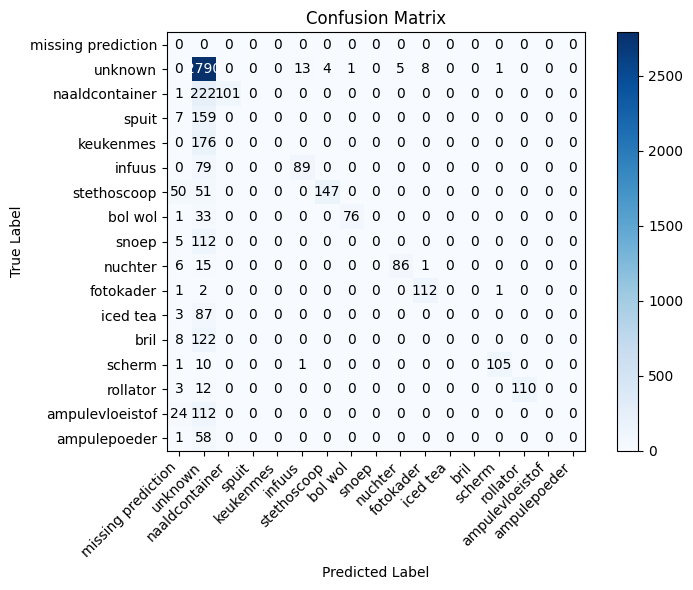

Best Grid Search Parameters:  (600, 10, 0.5)
Overall Accuracy: 0.7215
Known Accuracy: 0.8498
Per Class Metrics:
Class                 Precision     Recall         F1    Support
-----------------------------------------------------------------
missing prediction       0.0000     0.0000     0.0000          0
unknown                  0.6906     0.9887     0.8132       2822
naaldcontainer           1.0000     0.3117     0.4753        324
spuit                    0.0000     0.0000     0.0000        166
keukenmes                0.0000     0.0000     0.0000        176
infuus                   0.8641     0.5298     0.6568        168
stethoscoop              0.9735     0.5927     0.7368        248
bol wol                  0.9870     0.6909     0.8128        110
snoep                    0.0000     0.0000     0.0000        117
nuchter                  0.9451     0.7963     0.8643        108
fotokader                0.9256     0.9655     0.9451        116
iced tea                 0.0000     0.0000

In [7]:
best_grid_key = max(
    grid_search_metrics, key=lambda g: grid_search_metrics[g]["overall_accuracy"]
)

best_cm = grid_search_confusion_matrices[best_grid_key]

render_confusion_matrix(best_cm)
print("Best Grid Search Parameters: ", best_grid_key)
print_metrics(grid_search_metrics[best_grid_key])

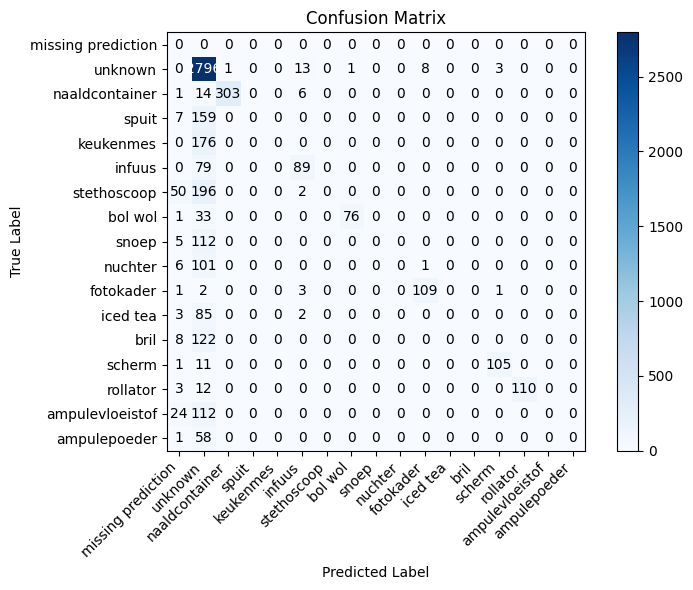

Overall Accuracy: 0.7159
Known Accuracy: 0.8390
Per Class Metrics:
Class                 Precision     Recall         F1    Support
-----------------------------------------------------------------
missing prediction       0.0000     0.0000     0.0000          0
unknown                  0.6873     0.9908     0.8116       2822
naaldcontainer           0.9967     0.9352     0.9650        324
spuit                    0.0000     0.0000     0.0000        166
keukenmes                0.0000     0.0000     0.0000        176
infuus                   0.7739     0.5298     0.6290        168
stethoscoop              0.0000     0.0000     0.0000        248
bol wol                  0.9870     0.6909     0.8128        110
snoep                    0.0000     0.0000     0.0000        117
nuchter                  0.0000     0.0000     0.0000        108
fotokader                0.9237     0.9397     0.9316        116
iced tea                 0.0000     0.0000     0.0000         90
bril                  

In [10]:
best_grid_key = max(
    grid_search_metrics, key=lambda g: grid_search_metrics[g]["known_accuracy"]
)

best_cm = grid_search_confusion_matrices[best_grid_key]

render_confusion_matrix(best_cm)
print_metrics(grid_search_metrics[best_grid_key])